# Project Name
## Image Detection of Rock, Paper, Scissors

In [ ]:
#necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn import metrics
import tensorflow_datasets as tfds
import zipfile,os,random,datetime

In [ ]:
tf.__version__

'2.14.0'

### Loading the dataset from tensorflow_datasets

In [ ]:
from tensorflow_datasets.core.dataset_info import MetadataDict
(train_data,test_data),Metadata=tfds.load(name="rock_paper_scissors",
                                split=['train','test'],
                                 as_supervised=True,
                                 with_info=True,
                                 shuffle_files=True,
                                 download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteSOWGRJ/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteSOWGRJ/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:
class_names=Metadata.features['label'].names

In [ ]:
# classnames
class_names

['rock', 'paper', 'scissors']

### Exploring the dataset

In [ ]:
# Becoming one with the data
take_a_sample=train_data.take(1)

tf.Tensor(1, shape=(), dtype=int64)
(300, 300, 3)


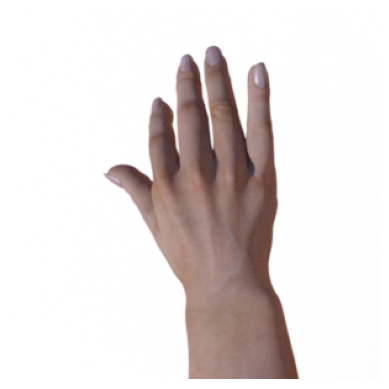

In [ ]:
for image,label in take_a_sample:
  plt.imshow(image)
  print(label)
  plt.axis(False)
  print(image.shape)

In [ ]:
print(f"""
  Image shape:{image.shape}
  Image datatype: {image.dtype}
  Label(in tensor form):{label}
  Label(in str form): {class_names[label.numpy()]}
      """)


  Image shape:(300, 300, 3)
  Image datatype: <dtype: 'uint8'>
  Label(in tensor form):1
  Label(in str form): paper
      


# Prepocessing the Data

In [ ]:
def preprocess_image(image,label,img_shape=224):
  #resize the image
  image=tf.image.resize(image,size=[img_shape,img_shape])
  #change its datatype
  image=tf.cast(image,dtype=tf.float32)
  return image,label

In [ ]:
image=preprocess_image(image,label)[0]

In [ ]:
print(f""" After processing the image
 Image shape:{image.shape}
  Image datatype: {image.dtype}
  Label(in tensor form):{label}
  Label(in str form): {class_names[label.numpy()]}
      """)

 After processing the image
 Image shape:(224, 224, 3)
  Image datatype: <dtype: 'float32'>
  Label(in tensor form):1
  Label(in str form): paper
      


(-0.5, 223.5, 223.5, -0.5)

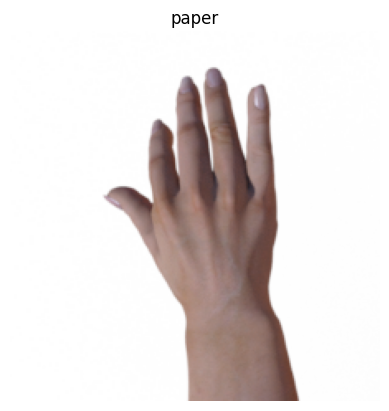

In [ ]:
plt.imshow(image/255.0)
plt.title(class_names[label.numpy()])
plt.axis('off')

In [ ]:
# preprocessing the data
# 1. train and test data into batches
# 2. AUTOTUNE: it sets the processors and the next batch to be excecuted readily available if the current execution of a batch completed
train_data=train_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
train_data=train_data.batch(batch_size=32).shuffle(buffer_size=len(train_data)).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
test_data=test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Creating necessary callbacks

In [ ]:
#create tensorboard callback
def create_tensorboard_callback(dirname,experiment_name):
  log_dir=dirname+'/'+experiment_name+'/'+datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir)
  return tensorboard_callback

In [ ]:
#create model checkpoint
checkpoint_path='model_checkpoints/cp.ckpt'
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                    monitor='val_accuracy',
                                    save_best_only=False,
                                    save_weights_only=True,
                                    verbose=0)

In [ ]:
# creating early stopping callback
early_stopping_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# creating learning rate scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

In [ ]:
# precision to 'mixed_float16' for faster computation process
from tensorflow.keras import mixed_precision,layers
mixed_precision.set_global_policy(policy='mixed_float16')

In [ ]:
# display our policy
mixed_precision.global_policy()

<Policy "mixed_float16">

### Dataaugmentation layer

In [ ]:
## dataaugmentation layer
data_augmention_layer=tf.keras.Sequential([
    layers.RandomFlip("horizontal"),#flips the image horizontaly
    layers.RandomRotation(0.2),#rotates the image
    layers.RandomZoom(0.2),#zooms the image
    layers.RandomHeight(0.2),#randomly heightens the image
    layers.Dropout(0.5)
],name="Dataaugmentation_layer")

# Creating our model
## Fine tuning with the ResNet50 model

In [ ]:
input_shape=(224,224,3)# input shape
base_model=tf.keras.applications.ResNet50(include_top=False)#exclude the top layer
base_model.trainable=False#inner layer training is set to false
inputs=layers.Input(shape=input_shape,name='Input_layer')
x=layers.Rescaling(1/255.0)(inputs)#scaling the inputs
x=data_augmention_layer(inputs)#data augmentation layer
x=base_model(inputs,training=False)#base model in inference mode
x=layers.GlobalMaxPooling2D(name='Pooling_layer')(x)#pooling layer
x=layers.Dense(len(class_names),kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)#Dense layer
outputs=layers.Activation(activation='softmax',dtype=tf.float32,name='Output_layer')(x)#output layer
model_1=tf.keras.Model(inputs,outputs)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
#compile the model
model_1.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),metrics=['accuracy'])

In [ ]:
#fit the model
history_1=model_1.fit(train_data,epochs=3,steps_per_epoch=len(train_data),
                      validation_data=test_data,validation_steps=len(test_data),
                      callbacks=[create_tensorboard_callback('project-1','model_1'),model_checkpoint,early_stopping_callback])

Epoch 1/3
79/79 [==============================] - 26s 100ms/step - loss: 4.1458 - accuracy: 0.8548 - val_loss: 2.0760 - val_accuracy: 0.8118
Epoch 2/3
79/79 [==============================] - 11s 57ms/step - loss: 0.1577 - accuracy: 0.9968 - val_loss: 1.4612 - val_accuracy: 0.8280
Epoch 3/3
79/79 [==============================] - 11s 65ms/step - loss: 0.1129 - accuracy: 1.0000 - val_loss: 0.9663 - val_accuracy: 0.8441


In [ ]:
def plot_loss_curves(history):
  loss=history.history['loss']
  accuracy=history.history['accuracy']
  val_loss=history.history['val_loss']
  val_accuracy=history.history['val_accuracy']
  epochs=range(len(history.history['loss']))
  #plot loss
  plt.plot(epochs,loss,label="Training loss")
  plt.plot(epochs,val_loss,label='Validation loss')
  plt.legend()
  plt.title("Loss Curves")
  plt.xlabel("epochs")
  #plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="Training Accuracy")
  plt.plot(epochs,val_accuracy,label="Validation Accuracy")
  plt.legend()
  plt.xlabel("epochs")
  plt.title("Accuracy curves")

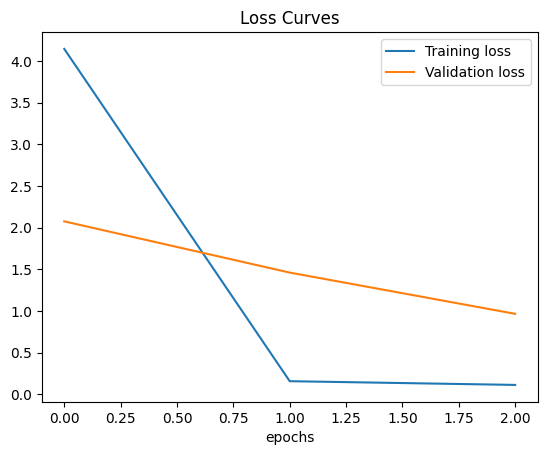

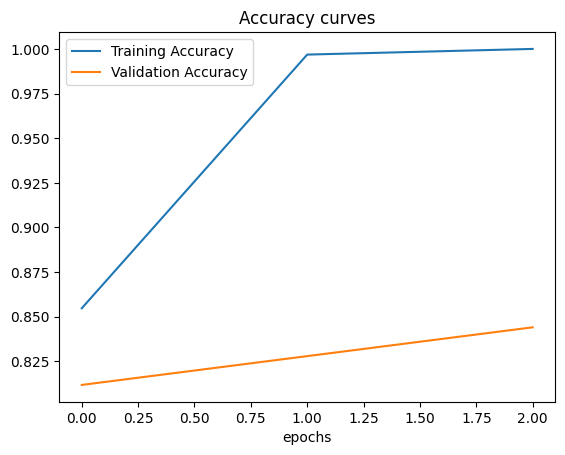

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 Pooling_layer (GlobalMaxPo  (None, 2048)              0         
 oling2D)                                                        
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
 Output_layer (Activation)   (None, 3)                 0         
                                                                 
Total params: 23593859 (90.00 MB)
Trainable params: 6147 (24.

In [ ]:
for layer in model_1.layers:
  print(layer)

In [ ]:
for layer in model_1.layers[1].layers:
  print(layer.name,layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

## unfreezing the some of the layers(Fine tuning)

In [ ]:
# set the inner layers training to true
base_model.trainable=True

In [ ]:
# the last 10 layers of the base model are set to true
for layer in model_1.layers[1].layers[:-10]:
  layer.trainable=False

In [ ]:
#the layers of the base model after traning
for layer in model_1.layers[1].layers:
  print(layer.name,layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [ ]:
input_shape=(224,224,3)
base_model=tf.keras.applications.ResNet50(include_top=False)
inputs=tf.keras.layers.Input(shape=input_shape,name="Input_layer")
x=layers.Rescaling(1/255.0)(inputs)
x=data_augmention_layer(inputs)
x=base_model(inputs,training=False)
x=layers.GlobalMaxPool2D(name="Pooling_layer")(x)
x=layers.Dense(len(class_names))(x)
outputs=layers.Activation(activation='softmax',dtype=tf.float32,name='Output_layer')(x)
model_2=tf.keras.Model(inputs,outputs)

In [ ]:
model_2.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),metrics=['accuracy'])

In [ ]:
final_epoch=5
history_2=model_2.fit(train_data,initial_epoch=history_1.epoch[-1],epochs=final_epoch,
                      validation_data=test_data,validation_steps=len(test_data),callbacks=[create_tensorboard_callback('project','model_2'),model_checkpoint,early_stopping_callback,])

Epoch 3/5
79/79 [==============================] - 60s 357ms/step - loss: 1.0476 - accuracy: 0.8893 - val_loss: 0.6814 - val_accuracy: 0.8575
Epoch 4/5
79/79 [==============================] - 19s 166ms/step - loss: 4.6700e-04 - accuracy: 1.0000 - val_loss: 0.6664 - val_accuracy: 0.8602
Epoch 5/5
79/79 [==============================] - 17s 163ms/step - loss: 2.8002e-04 - accuracy: 1.0000 - val_loss: 0.6652 - val_accuracy: 0.8629


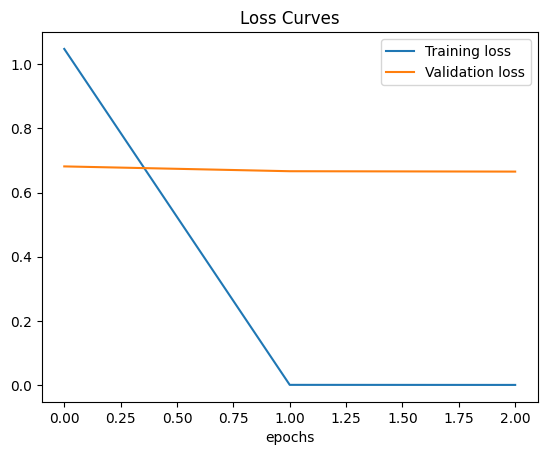

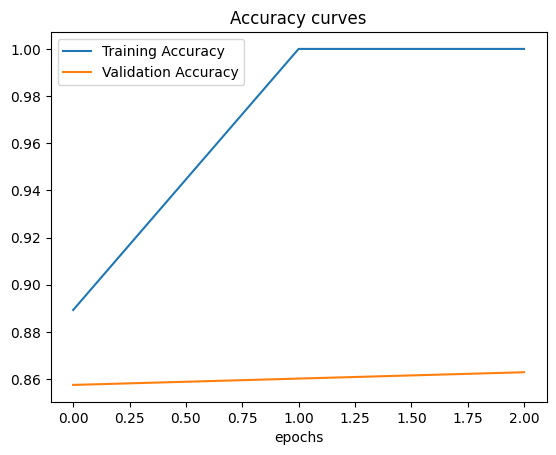

In [ ]:
plot_loss_curves(history_2)
#Overfitting

In [ ]:
results_2=model_2.evaluate(test_data)

12/12 [==============================] - 1s 51ms/step - loss: 0.6652 - accuracy: 0.8629


In [ ]:
results_1=model_1.evaluate(test_data)

12/12 [==============================] - 1s 43ms/step - loss: 0.9663 - accuracy: 0.8441


In [ ]:
print(f"In Model_1 fine tuning is done of\n loss: {results_1[0]}\n accuracy:{results_1[1]*100:.2f}%")

In Model_1 fine tuning is done of
 loss: 0.966267466545105
 accuracy:84.41%


In [ ]:
print(f"In Model_2 fine tuning is done of\n loss: {results_2[0]}\n accuracy:{results_2[1]*100:.2f}%")

In Model_2 fine tuning is done of
 loss: 0.66518235206604
 accuracy:86.29%


# Making Predictions

In [ ]:
def prep_and_pred_image(filepath,image_shape=224,scale=True):
  #read the image
  image=tf.io.read_file(filepath)
  #decode the image
  image=tf.io.decode_image(image,channels=3)
  #resize the image
  image=tf.image.resize(image,size=[image_shape,image_shape])
  if scale:
    image= image/255.0
  pred_probs=model_2.predict(tf.expand_dims(image,axis=0))
  pred_class=class_names[pred_probs.argmax()]
  print(pred_probs,pred_class)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"predicted class:{pred_class}, prob:{pred_probs.max():.3f}")

In [ ]:
!wget http://1000awesomethings.com/wp-content/uploads/2008/08/scissors.jpg

--2023-11-13 16:19:21--  http://1000awesomethings.com/wp-content/uploads/2008/08/scissors.jpg
Resolving 1000awesomethings.com (1000awesomethings.com)... 162.241.251.79
Connecting to 1000awesomethings.com (1000awesomethings.com)|162.241.251.79|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://1000awesomethings.com/wp-content/uploads/2008/08/scissors.jpg [following]
--2023-11-13 16:19:21--  https://1000awesomethings.com/wp-content/uploads/2008/08/scissors.jpg
Connecting to 1000awesomethings.com (1000awesomethings.com)|162.241.251.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21721 (21K) [image/jpeg]
Saving to: ‘scissors.jpg.4’

scissors.jpg.4      100%[===================>]  21.21K  --.-KB/s    in 0.04s   

2023-11-13 16:19:21 (566 KB/s) - ‘scissors.jpg.4’ saved [21721/21721]



1/1 [==============================] - 0s 26ms/step
[[0.01072498 0.9203226  0.06895234]] paper


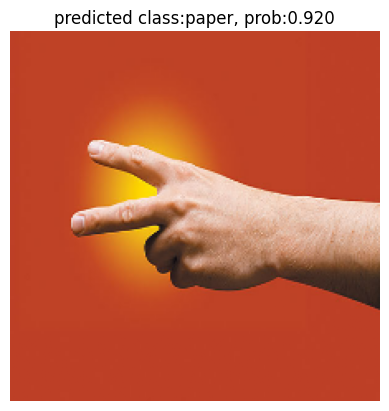

In [ ]:
prep_and_pred_image('/content/scissors.jpg')

1/1 [==============================] - 0s 58ms/step
[[0.00902486 0.9250668  0.06590831]] paper


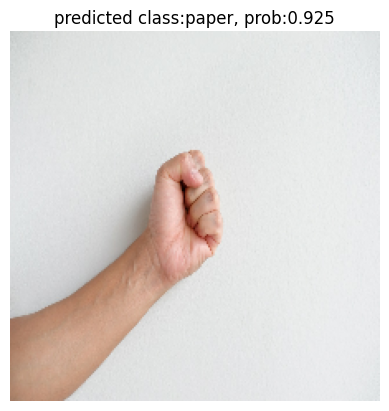

In [ ]:
prep_and_pred_image('/content/hand-2704013_1280.jpg')

In [ ]:
!wget https://tse4.mm.bing.net/th?id=OIP.o4SK46MwwJInumHyCpbZmgHaHa&pid=Api&P=0&h=180

--2023-11-13 16:13:16--  https://tse4.mm.bing.net/th?id=OIP.o4SK46MwwJInumHyCpbZmgHaHa
Resolving tse4.mm.bing.net (tse4.mm.bing.net)... 204.79.197.200, 13.107.21.200, 2620:1ec:c11::200
Connecting to tse4.mm.bing.net (tse4.mm.bing.net)|204.79.197.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19201 (19K) [image/jpeg]
Saving to: ‘th?id=OIP.o4SK46MwwJInumHyCpbZmgHaHa’

th?id=OIP.o4SK46Mww 100%[===================>]  18.75K  --.-KB/s    in 0s      

2023-11-13 16:13:16 (313 MB/s) - ‘th?id=OIP.o4SK46MwwJInumHyCpbZmgHaHa’ saved [19201/19201]



1/1 [==============================] - 0s 30ms/step
[[0.03812242 0.9017854  0.06009223]] paper


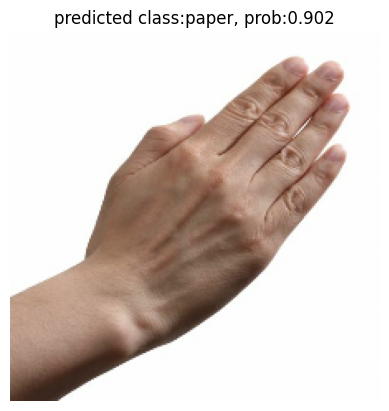

In [ ]:
prep_and_pred_image('/content/th?id=OIP.o4SK46MwwJInumHyCpbZmgHaHa')

In [ ]:
print(class_names)

['rock', 'paper', 'scissors']


In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Rock-paper-scissors_(scissors).png/100px-Rock-paper-scissors_(scissors).png

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `wget https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Rock-paper-scissors_(scissors).png/100px-Rock-paper-scissors_(scissors).png'


1/1 [==============================] - 0s 23ms/step
[[0.03812242 0.9017854  0.06009223]] paper


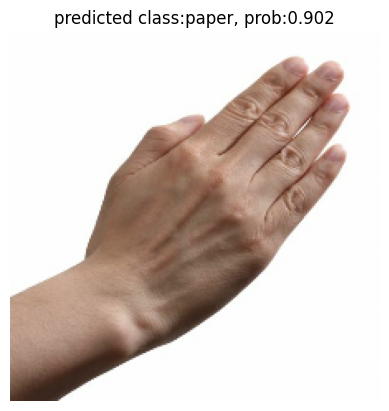

In [ ]:
prep_and_pred_image('/content/th?id=OIP.o4SK46MwwJInumHyCpbZmgHaHa')

# Results
Our model is likely to overfit on the dataset and this project will be optimized, mean overcoming from overfitting. Thank you